Having fit the data with our full model, we need to show how it can be used to make a decision for the client. In this case, the client is interested in maximising profit (i.e clicks times price). Changing price and position on shelf has an impact on profit, but in reality the client has no choice on what position the product is placed. Therefore, the descision that needs to be made is what is the best price to put the product at to maxmise profit.

We now have a model that relates position, product and product position to number of clicks, and the uncertianty on number of clicks. Bayesian decision making will give us a way to take model predicitions and associated uncertianty and use it to select the optimal price to make profit.

In [ ]:
pred_matrix[z,i,j]=m[z]*price_pred[i] + c[z,j];
pred_matrix_select[z,i,j]=bernoulli_logit_rng(pred_matrix[z,i,j]);

In [1]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns

### Load the model and fit

In [2]:
import pickle
with open("model_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
fit_infer = data_dict['fit']

In [9]:
from scipy.special import expit
from scipy.stats import bernoulli

In [19]:
@np.vectorize
def expit_vec(x):
    return 1.0/(1.0+np.exp(-x))

## Define Loss function
Now we have our predicitions for clicks, we need to come up with a loss function. This function should define the cost of what happens to turnover when we change price. For example, too high and the turnover will drop as the number of clicks drops off. First, lets define some useful number which will be needed to make the decision:

* write loss function
* write objective function: The objective function takes the posterior probability distribution on clicks from our model and applies it to the loss function. It does this as a function of price
    . take price, product and give probability of clicks, give this to loss function

In [52]:
data=pd.read_csv('../../../data/raw/priced_shelves_data.csv')
data['id.session_int']=data.groupby('id.session').grouper.group_info[0]+1
data['selected_int']=data.groupby('selected').grouper.group_info[0]
data['product_int']=data.groupby('product').grouper.group_info[0]+1
data['mean_sub_price']=data['price']-data.groupby('product').transform('mean')['price']
#get mean price, sorted by product_int
mean_price=data.groupby('product_int').describe()['price']['mean'].values

In [213]:
MAX_PRICE=20
MIN_PRICE=5
N=1000
COST=5.0

In [196]:
def loss_function(price,n):
    return -1.0*(price-COST)*n

In [234]:
@np.vectorize
def objective(price,max_price=MAX_PRICE,min_price=MIN_PRICE,n=N,i=0,pos=0):
    losses = []
    
    # Prices_outside range, indicated by np.inf
    if np.any(price < min_price):
        return np.inf
    if np.any(price > max_price):
        return np.inf
    click_dist=expit_vec(fit_infer['m'][:,i]*(price-mean_price[i]) + fit_infer['c'][:,i,pos])
    # Iterate over post pred samples provided in click_dist
    for i in range(0,click_dist.size):
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i=loss_function(price,N*click_dist[i])
        losses.append(loss_i)
    return np.asarray(losses)

In [225]:
counts_data=[]
counts_rep=[]
for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    print(z)
    ind=fit_infer.data['product']==pro
    for i,pi in enumerate(np.unique(fit_infer.data['kk'][ind])):
        ind_2=(fit_infer.data['product']==pro) & (fit_infer.data['kk']==pi)
        for j,pri in enumerate(np.unique(fit_infer.data['price'][ind])):
            ind_all=(fit_infer.data['kk']==pi) & (fit_infer.data['price'].values == pri) & (fit_infer.data['product'].values == pro)
            ind_select=fit_infer.data['y'][ind_all].values==1
            counts_data.append([pro,pi,pri,ind_select.sum()/ind_all.sum()])
            ind_dist=fit_infer['y_rep'][:,ind_all]==1
            counts_rep.append([ind_dist.sum(axis=1)/ind_all.sum()])
            
counts_data=np.asarray(counts_data)
#counts_rep=np.vstack(counts_rep).T

0
1
2
3
4
5
6
7
8
9
10
11
12
13


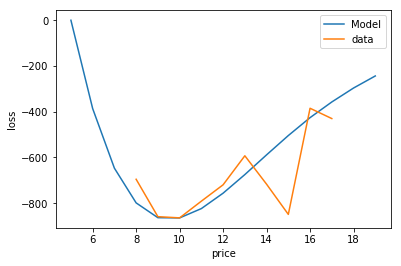

In [226]:
tmp=[]
for i,p in enumerate(np.arange(5,20)):
    tmp.append(np.median(objective(p,i=0)))
tmp=np.asarray(tmp)
plt.plot(np.arange(5,20),tmp,label='Model')
plt.xlabel('price')
plt.ylabel('loss')
plt.plot(counts_data[(counts_data[:,0]==1) & (counts_data[:,1]==3)][:,2]+mean_price[0],
         loss_function(counts_data[(counts_data[:,0]==1) &
                                   (counts_data[:,1]==3)][:,2]+mean_price[0],N*counts_data[(counts_data[:,0]==1) & (counts_data[:,1]==3)][:,3]),label='data')
plt.legend()

In [ ]:

tmp
for 
for i,p in enumerate(np.arange(5,20)):
    tmp.append(np.median(objective(p,i=0)))
tmp=np.asarray(tmp)
plt.plot(np.arange(5,20),tmp,label='Model')
plt.xlabel('price')
plt.ylabel('loss')
plt.plot(counts_data[(counts_data[:,0]==1) & (counts_data[:,1]==3)][:,2]+mean_price[0],
         loss_function(counts_data[(counts_data[:,0]==1) &
                                   (counts_data[:,1]==3)][:,2]+mean_price[0],N*counts_data[(counts_data[:,0]==1) & (counts_data[:,1]==3)][:,3]),label='data')
plt.legend()


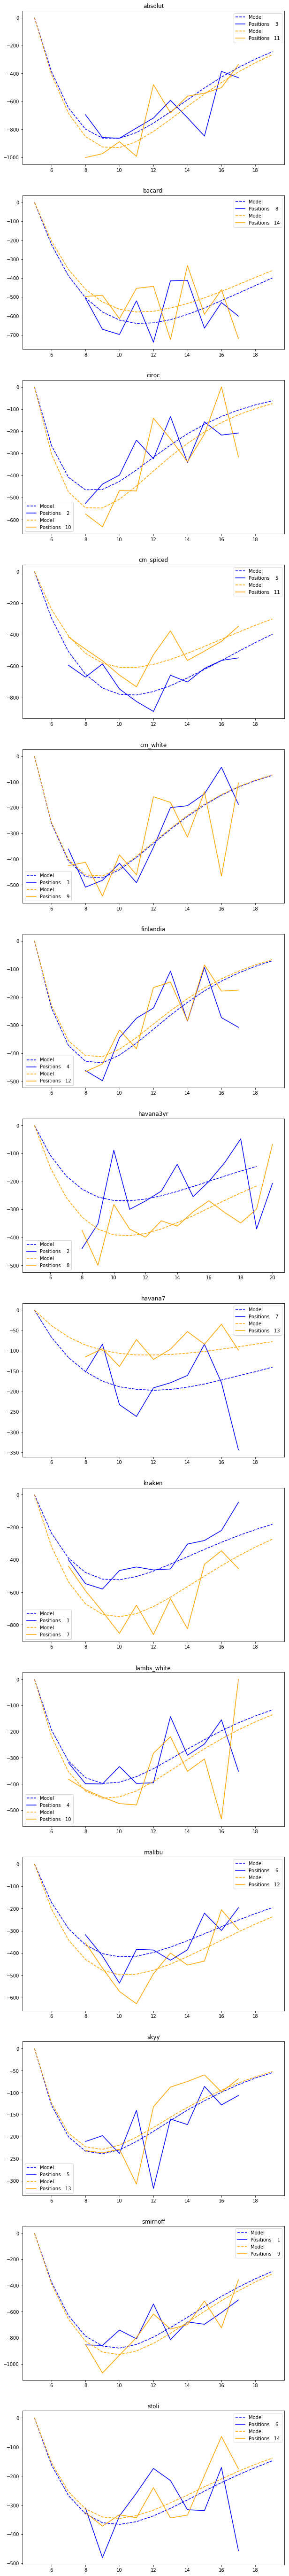

In [235]:
plt.figure(figsize=(10,100))
color=['blue','orange','green','red']

for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    ind=fit_infer.data['product']==pro
    plt.subplot(np.unique(fit_infer.data['product'].values).size,1,z+1)
    for i,pi in enumerate(np.unique(fit_infer.data['kk'][ind])):
        tmp=[]
        for t,pri in enumerate(np.arange(5,20)):
            tmp.append(np.median(objective(pri,i=pro-1,pos=pi-1)))
        tmp=np.asarray(tmp)
        plt.plot(np.arange(5,20),tmp,'--',label='Model',color=color[i])
        ind_plot=(counts_data[:,0]==pro) & (counts_data[:,1]==pi)
        plt.plot(counts_data[ind_plot,2]+mean_price[z],
                 loss_function(counts_data[ind_plot,2]+mean_price[z],N*counts_data[ind_plot,3]),color=color[i],label='Positions {:4.0f}'.format(pi))
        plt.legend()
        plt.title(np.unique(data[data['product_int']==pro]['product'])[0])